# BCI Data Collection

Five sheep were anaesthetised and implanted with two BCIs (Stentrode, ECoG) near the primary visual cortex. The BCIs recorded brain activity whilst the sheep looked at different colour screens for 100 trials. Each trial lasted ~ 12 seconds, and contained a randomised order of red, green or blue screen interleaved with the control/grey screen (shown below).

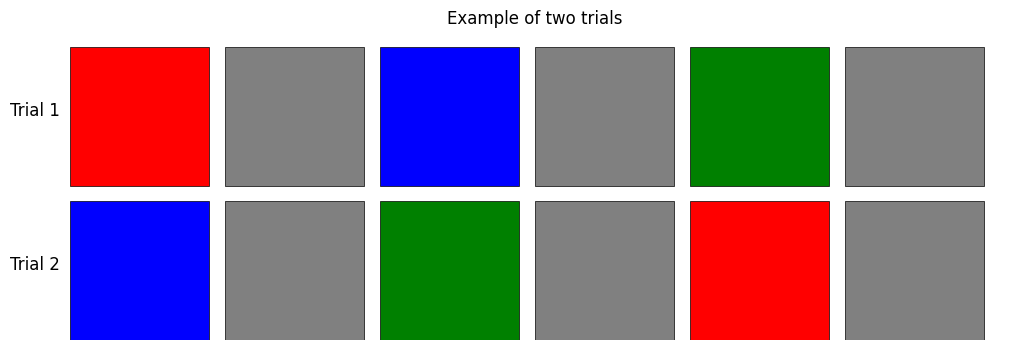

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

fig, ax = plt.subplots(figsize=(12, 4))

rows = 2
cols = 6
spacing = 0.1
rect_width = 1 - spacing
rect_height = 1 - spacing
radius = 0.1  # Radius of rounded corners

colors = [['red', 'grey', 'blue', 'grey', 'green', 'grey'],
          ['blue', 'grey', 'green', 'grey', 'red', 'grey']]

# Define durations
durations = [['2.0', '1.5 - 2.5', '2.0', '1.5 - 2.5', '2.0', '1.5 - 2.5'],
             ['2.0', '1.5 - 2.5', '2.0', '1.5 - 2.5', '2.0', '1.5 - 2.5']]

positions = [(i, j) for i in range(rows) for j in range(cols)]

for (i, j), color, duration in zip(positions, np.array(colors).flatten(), np.array(durations).flatten()):
    rect = patches.Rectangle((j * (rect_width + spacing), (rows-i-1) * (rect_height + spacing)), 
                             rect_width, rect_height, linewidth=0.5, edgecolor='black', facecolor=color)
    ax.add_patch(rect)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(0, cols * (rect_width + spacing))
ax.set_ylim(0, rows * (rect_height + spacing))
ax.set_yticks([0.5 * (rect_height + spacing), 1.5 * (rect_height + spacing)])
ax.set_yticklabels(['Trial 2', 'Trial 1'], fontsize=12)
ax.tick_params(left=False, bottom=False, labelleft=True)

ax.spines[:].set_visible(False)
ax.set_title("Example of two trials")

plt.show()


# Visualise processed BCI data

In [2]:
device = "ecog" # ECoG or Stentrode BCI devices
protocol = 4 # sheep label (5 sheep total)
factor = 6 # downsample

dir = f'/kaggle/input/protocol-{protocol}/'
X_file_name = f'X_{device}_protocol_{protocol}.npy'
y_file_name = f'y_{device}_protocol_{protocol}.npy'

X = np.load(dir+X_file_name)
y = np.load(dir+y_file_name)

X = X[:,:,::factor]

red = []
green = []
blue = []
control = []

for i in range(len(y)):
    ind = y[i]
    if ind == 0:
        red.append(X[i])
    elif ind == 1:
        green.append(X[i])
    elif ind == 2:
        blue.append(X[i])
    elif ind == 3:
        control.append(X[i])
    else:
        print("OOPS")

ch_avg_red = np.mean(red, axis=0)
ch_avg_green = np.mean(green, axis=0)
ch_avg_blue = np.mean(blue, axis=0)
ch_avg_control = np.mean(control, axis=0)

global_avg_red = np.mean(ch_avg_red,0)
global_avg_green = np.mean(ch_avg_green,0)
global_avg_blue = np.mean(ch_avg_blue,0)
global_avg_control = np.mean(ch_avg_control,0)

Text(0.5, 1.0, 'Processed data separated by colour stimulus')

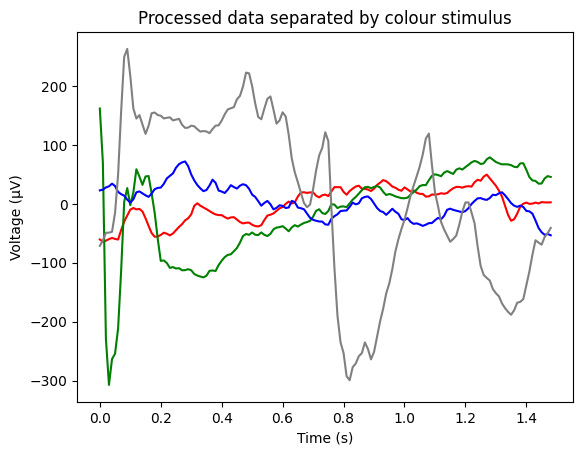

In [3]:
sf = 100
t = np.arange(149) / sf

plt.plot(t, global_avg_red, color='red')
plt.plot(t, global_avg_green, color='green')
plt.plot(t, global_avg_blue, color='blue')
plt.plot(t, global_avg_control, color='grey')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (µV)')
plt.title('Processed data separated by colour stimulus')

# Predict colour on processed data using ML models

In [4]:
import pandas as pd
import seaborn as sns

from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tensorflow.keras import utils as np_utils

In [5]:
def get_RF_results(X_train, y_train, X_test, y_test):
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

    # Fit a model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions on test set
    predictions = model.predict(X_test) 

    # Confusion matrix
    cm = confusion_matrix(y_test, predictions, normalize='true')
    
    # Accuracy
    acc = accuracy_score(y_test, predictions)
        
    return cm, acc

In [6]:
# Adaptation of Schirrmeister2017 "Deep learning with convolutional neural networks for EEG decoding and visualization"

def CNN(nb_classes, Chans, Samples, dropoutRate):

    input_main   = Input((Chans, Samples, 1))
    block1       = Conv2D(25, (1, 5),
                                 input_shape=(Chans, Samples, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(25, (Chans, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block1)
    block1       = Activation('elu')(block1)
    block1       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block1)
    block1       = Dropout(dropoutRate)(block1)

    block2       = Conv2D(50, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block2       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block2)
    block2       = Activation('elu')(block2)
    block2       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block2)
    block2       = Dropout(dropoutRate)(block2)

    block3       = Conv2D(100, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block2)
    block3       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block3)
    block3       = Activation('elu')(block3)
    block3       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block3)
    block3       = Dropout(dropoutRate)(block3)

    block4       = Conv2D(200, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block3)
    block4       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block4)
    block4       = Activation('elu')(block4)
    block4       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block4)
    block4       = Dropout(dropoutRate)(block4)

    flatten      = Flatten()(block4)

    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)

    return Model(inputs=input_main, outputs=softmax)

In [7]:
cm_all_rf = np.zeros([len(set(y)),len(set(y))])
acc_all_rf = []
cm_all_cnn = np.zeros([len(set(y)),len(set(y))])
acc_all_cnn = []

# CNN hyperparam
kerns, chans, samples = 1, X.shape[1], X.shape[2]
batch_size = 16
epochs = 300

repeats = 10

for i in range(repeats):
    print("i", i)
    
    # test_data is 1st 1/3
    if i % 2 == 0:
        test_split = X.shape[0]//3
        X_test = X[:test_split, :, :]
        y_test = y[:test_split]
        X_train = X[test_split:, :, :]
        y_train = y[test_split:]
    # test_data is last 1/3
    else:
        test_split = (X.shape[0]//3) * 2
        X_train = X[:test_split, :, :]
        y_train = y[:test_split]
        X_test = X[test_split:, :, :]
        y_test = y[test_split:]
        
    # Shuffle data
    permutation_train = np.random.permutation(len(X_train))
    permutation_test = np.random.permutation(len(X_test))
    X_train = X_train[permutation_train]
    y_train = y_train[permutation_train]
    X_test = X_test[permutation_test]
    y_test = y_test[permutation_test]
    
    # RF
    cm_rf, acc_rf = get_RF_results(X_train, y_train, X_test, y_test)
    cm_all_rf += cm_rf
    acc_all_rf.append(acc_rf)
    print("RF: ", acc_rf)

    # CNN
    X_train = X_train.reshape(X_train.shape[0], chans, samples, kerns)
    X_test = X_test.reshape(X_test.shape[0], chans, samples, kerns)
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    
    model = CNN(nb_classes = 4, Chans = chans, Samples = samples, dropoutRate = 0.5)

    model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics = ['accuracy'])
    
    fittedModel = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs,
                            verbose = 0)

    probs = model.predict(X_test)
    preds = probs.argmax(axis = -1)

    # Confusion matrix
    cm_cnn = confusion_matrix(y_test.argmax(axis=-1), preds, normalize='true')
    
    # Accuracy
    acc_cnn = np.mean(preds == y_test.argmax(axis=-1))
    cm_all_cnn += cm_cnn
    acc_all_cnn.append(acc_cnn)
    print("CNN: ", acc_cnn)

labels = ['Red', 'Green', 'Blue', 'Control']


cm_all_rf = cm_all_rf/repeats
cm_df_rf = pd.DataFrame(cm_all_rf, index=labels, columns=labels)

cm_all_cnn = cm_all_cnn/repeats
cm_df_cnn = pd.DataFrame(cm_all_cnn, index=labels, columns=labels)

i 0
RF:  0.7969924812030075


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1727694682.823214      77 service.cc:145] XLA service 0x795024001de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727694682.823274      77 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1727694692.286205      77 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step
CNN:  0.8120300751879699
i 1
RF:  0.7388059701492538


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
CNN:  0.8656716417910447
i 2
RF:  0.8120300751879699


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
CNN:  0.8646616541353384
i 3
RF:  0.746268656716418


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
CNN:  0.8955223880597015
i 4
RF:  0.8345864661654135


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
CNN:  0.8571428571428571
i 5
RF:  0.746268656716418


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
CNN:  0.835820895522388
i 6
RF:  0.8195488721804511


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
CNN:  0.8270676691729323
i 7
RF:  0.7313432835820896


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
CNN:  0.8731343283582089
i 8
RF:  0.8646616541353384


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
CNN:  0.7969924812030075
i 9
RF:  0.7611940298507462


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
CNN:  0.835820895522388


Text(0.5, 1.0, 'RF Accuracy: 78.52 (75.79, 81.25)')

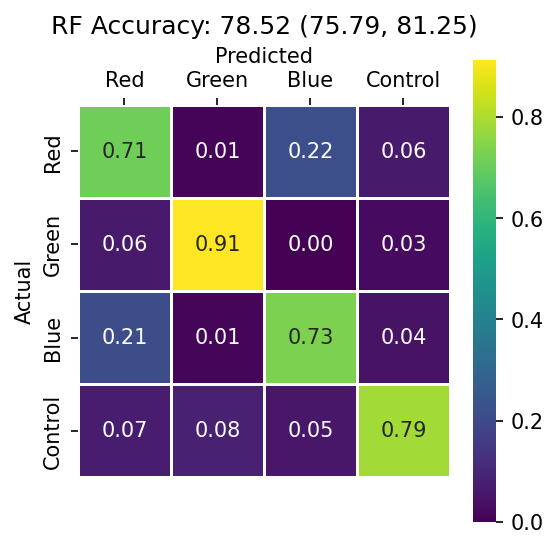

In [8]:
# Plot confusion matrix (RF)
plt.figure(figsize=(4,4), dpi=150)
sns.heatmap(cm_df_rf, annot=True, fmt='.2f', linewidths=.5, square = True, cmap = 'viridis')
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()

plt.ylabel('Actual')
plt.xlabel('Predicted')

acc = round(np.mean(acc_all_rf), 4)
acc_mean = round(acc * 100, 2)
CI = round(1.96 * np.std(acc_all_rf) / np.sqrt(len(acc_all_rf)), 4) # 95% CI
acc_range = round(CI * 100, 2)
low = round(acc_mean - acc_range, 2)
high = round(acc_mean + acc_range, 2)
all_sample_title = f'{acc_mean} ({low}, {high})'
plt.title("RF Accuracy: " + all_sample_title)

Text(0.5, 1.0, 'CNN Accuracy: 84.64 (82.87, 86.41)')

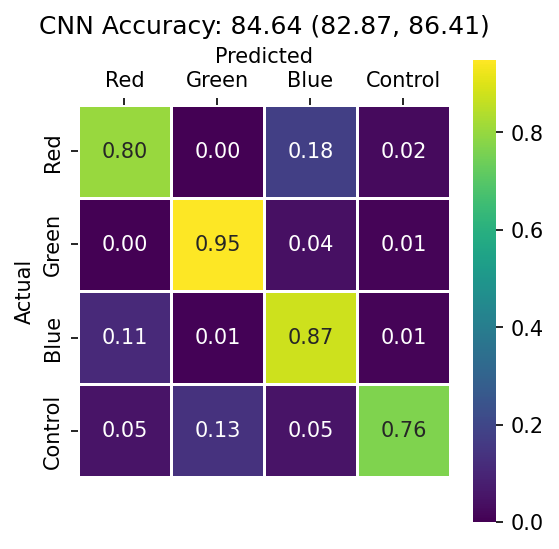

In [9]:
# Plot confusion matrix (CNN)
plt.figure(figsize=(4,4), dpi=150)
sns.heatmap(cm_df_cnn, annot=True, fmt='.2f', linewidths=.5, square = True, cmap = 'viridis')
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()

plt.ylabel('Actual')
plt.xlabel('Predicted')

acc = round(np.mean(acc_all_cnn), 4)
acc_mean = round(acc * 100, 2)
CI = round(1.96 * np.std(acc_all_cnn) / np.sqrt(len(acc_all_cnn)), 4) # 95% CI
acc_range = round(CI * 100, 2)
low = round(acc_mean - acc_range, 2)
high = round(acc_mean + acc_range, 2)
all_sample_title = f'{acc_mean} ({low}, {high})'
plt.title("CNN Accuracy: " + all_sample_title)

# Visualise important features in data for CNN colour prediction

In [10]:
import tensorflow as tf

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, normalise the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy().reshape(1, -1)

In [11]:
model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 28, 149, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 28, 145, 25)    │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 1, 145, 25)     │        17,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 1, 145, 25)     │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_45 (Activation)      │ (None, 1, 145, 25)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 1, 72, 25)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 1, 72, 25)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 1, 68, 50)      │         6,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 1, 68, 50)      │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_46 (Activation)      │ (None, 1, 68, 50)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 1, 34, 50)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 1, 34, 50)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 1, 30, 100)     │        25,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 1, 30, 100)     │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_47 (Activation)      │ (None, 1, 30, 100)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 1, 15, 100)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 1, 15, 100)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 1, 11, 200)     │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 1, 11, 200)     │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_48 (Activation)      │ (None, 1, 11, 200)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 1, 5, 200)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 1, 5, 200)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 1000)           │             

 Total params: 462,839 (1.77 MB)

 Trainable params: 154,029 (601.68 KB)

 Non-trainable params: 750 (2.93 KB)

 Optimizer params: 308,060 (1.18 MB)

In [13]:
y_test_new = y_test.argmax(axis=-1)
t = np.arange(X_test.shape[2]) / 100
n_correct = np.sum(y_test_new == preds)
last_conv_layer_name = "conv2d_49"
heatmap_arr = np.zeros([1, 11])

for index in range(len(X_test)):
    actual = y_test_new[index]
    predicted = preds[index]
    if actual != predicted:
        continue
    test_data = X_test[index]
    test_array = test_data.reshape(test_data.shape[2], test_data.shape[0], test_data.shape[1])

    heatmap = make_gradcam_heatmap(test_array, model, last_conv_layer_name)
    heatmap_arr += heatmap
    
heatmap_data_last = heatmap_arr/n_correct

In [14]:
red = []
green = []
blue = []
control = []

norm_X = (X - X.min()) / (X.max() - X.min())

for i in range(len(y)):
    ind = y[i]
    if ind == 0:
        red.append(norm_X[i])
    elif ind == 1:
        green.append(norm_X[i])
    elif ind == 2:
        blue.append(norm_X[i])
    elif ind == 3:
        control.append(norm_X[i])
    else:
        print("OOPS")

In [15]:
ch_avg_red = np.mean(red, axis=0)
ch_avg_green = np.mean(green, axis=0)
ch_avg_blue = np.mean(blue, axis=0)
ch_avg_control = np.mean(control, axis=0)

global_avg_red = np.mean(ch_avg_red,0)
global_avg_green = np.mean(ch_avg_green,0)
global_avg_blue = np.mean(ch_avg_blue,0)
global_avg_control = np.mean(ch_avg_control,0)
global_min = np.min(np.concatenate([global_avg_red, global_avg_green, global_avg_blue, global_avg_control]))
global_max = np.max(np.concatenate([global_avg_red, global_avg_green, global_avg_blue, global_avg_control]))

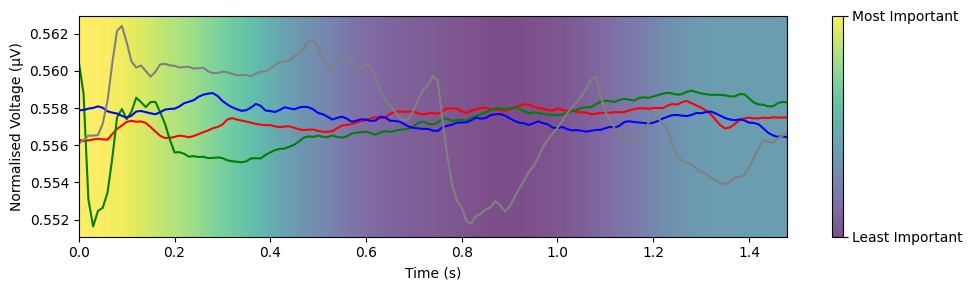

In [16]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10,3))

# Plot the 2D heatmap
cax = ax.imshow(heatmap_data_last, aspect='auto', extent=[t[0], t[-1], 0, heatmap.shape[1]], cmap='viridis', alpha=0.7, interpolation="Gaussian")
cbar = fig.colorbar(cax, ax=ax, orientation='vertical')

ticks = [heatmap_data_last.min(), heatmap_data_last.max()]
tick_labels = ['Least Important', 'Most Important']
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels)

# Plot the time vs. voltage graph
ax.plot(t, global_avg_red, color='red')
ax.plot(t, global_avg_green, color='green')
ax.plot(t, global_avg_blue, color='blue')
ax.plot(t, global_avg_control, color='grey')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Normalised Voltage (µV)')
ax.set_ylim(global_min*0.999, global_max*1.001)
plt.tight_layout()
plt.show()
